# Modèle SVM pour détecter les risques de cancer cervical
par Binh Minh TRAN

## 1. Télechargement des packages nécessaires

In [1]:
# 1. Manipulation des données
import numpy as np
import pandas as pd

# 2. Sérialisation des objets Python
import pickle

# 3. Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns

# 4. Prétraitement des données
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 5. Modélisation
from sklearn import svm
from sklearn.svm import SVC

# 6. Évaluation du modèle (Model Evaluation)
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

# 7. Validation croisée et recherche de paramètres
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit

# 8. Traitement des étiquettes
from sklearn.preprocessing import label_binarize

# 9. Outils supplémentaires
from collections import Counter

# 10. Fonctions personnalisées
from fonctionUtile import * 

## 2. Importation des ensembles d'entraînement et de test (validation croisée)

In [2]:
with open('variables.pkl', 'rb') as f:
    (fold_indices, df, X_train, X_test, y_train, y_test,
                 X_train_1, Y_train_1, X_train_2, Y_train_2, 
                 X_train_3, Y_train_3, X_train_4, Y_train_4, 
                 X_train_5, Y_train_5,  
                 X_test_1, Y_test_1, X_test_2, Y_test_2, 
                 X_test_3, Y_test_3, X_test_4, Y_test_4,
                 X_test_5, Y_test_5, ) = pickle.load(f)

In [3]:
list_X_train = [X_train_1, X_train_2, X_train_3, X_train_4, X_train_5]
list_Y_train = [Y_train_1, Y_train_2, Y_train_3, Y_train_4, Y_train_5]
list_X_test = [X_test_1, X_test_2, X_test_3, X_test_4, X_test_5]
list_Y_test = [Y_test_1, Y_test_2, Y_test_3, Y_test_4, Y_test_5]

## 3. Vérification de la séparation linéaire avec SVM

Avec 19 attributs, on ne peut pas visualiser, donc on effectue une PCA pour projeter l'ensemble d'entraînement dans un espace à 2 dimensions et effectuer un SVM avec un noyau linéaire. On applique la PCA pour déterminer si nous devons utiliser un noyau non linéaire pour le SVM.

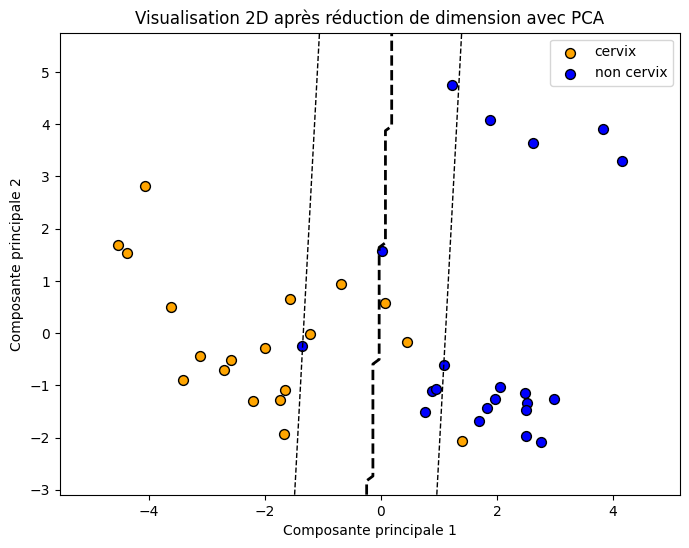

In [4]:
pca_et_visualisation(X_train_1, Y_train_1)

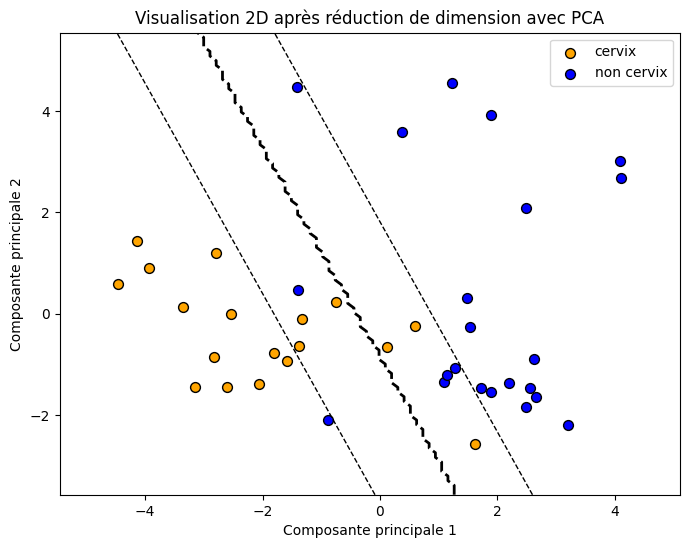

In [5]:
pca_et_visualisation(X_train_2, Y_train_2)

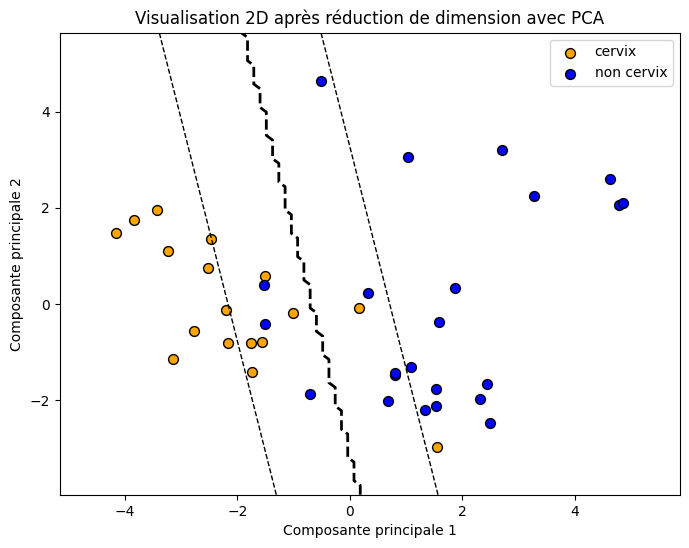

In [6]:
pca_et_visualisation(X_train_3, Y_train_3)

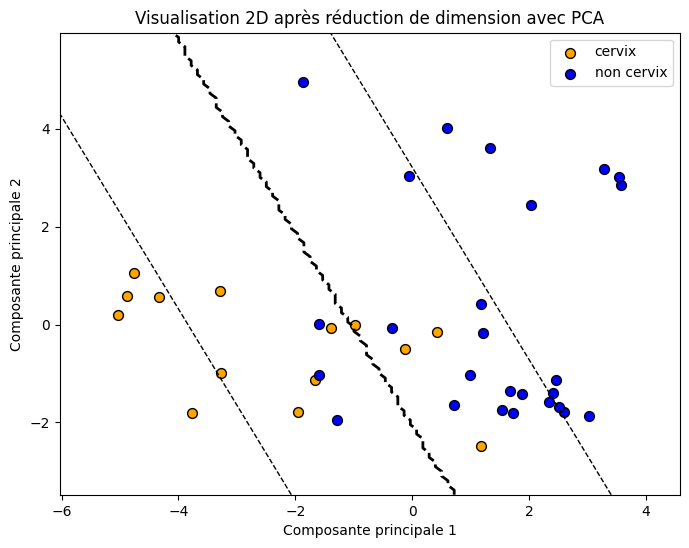

In [7]:
pca_et_visualisation(X_train_4, Y_train_4)

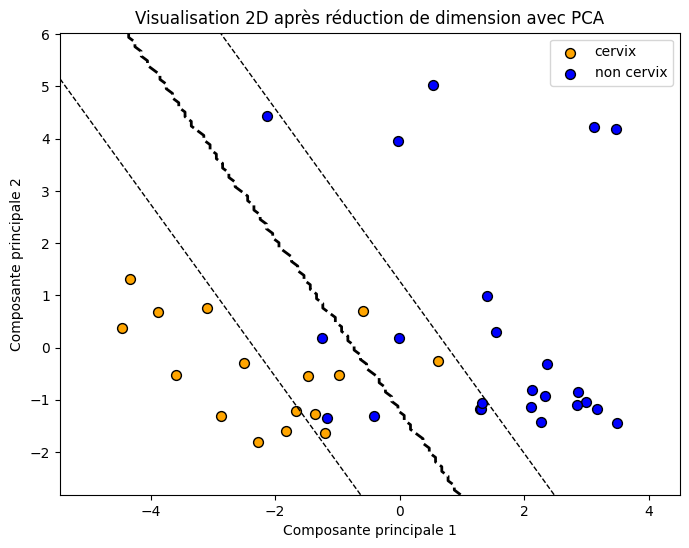

In [8]:
pca_et_visualisation(X_train_5, Y_train_5)

On peut évidemment observer la séparation linéaire dans les 5 ensembles d'entraînement, mais elle n'est pas clairement définie. Cependant, nous allons tout de même essayer d'entraîner le modèle avec un noyau linéaire.

## 4. SVM

### 4.1 Optimisation des hyperparamètres de SVM avec Cross-Validation

L'algorithme SVM possède un paramètre C qui doit être optimisé, mais la taille de l'ensemble de données est réduite (72 individus). Par conséquent, la recherche du paramètre C optimal en divisant simplement l'ensemble en ensembles d'entraînement et de test risquerait de provoquer un surapprentissage (overfitting). C'est pourquoi nous utilisons la validation croisée pour déterminer la valeur optimale de C.

In [9]:
scores = []
f1_scores = []
best_C_values = []

for i in range(5):
    X_tr, X_t = list_X_train[i], list_X_test[i]  # Prendre les données d'entraînement et de test pour le pli i
    y_tr, y_t = list_Y_train[i], list_Y_test[i]  # Prendre les étiquettes d'entraînement et de test pour le pli i
    
    # Prétraitement des données: normalisation des données d'entraînement et de test
    scaler = StandardScaler()  # Initialisation du standardiseur
    X_train_scaled = scaler.fit_transform(X_tr)  # Normalisation des données d'entraînement
    X_test_scaled = scaler.transform(X_t)  # Normalisation des données de test

    # Réduction de la dimension avec PCA: nous conservons 90% de la variance
    pca = PCA(n_components=0.9)  # Initialisation de PCA pour réduire la dimension
    X_train_pca = pca.fit_transform(X_train_scaled)  # Appliquer PCA sur les données d'entraînement
    X_test_pca = pca.transform(X_test_scaled)  # Appliquer PCA sur les données de test
    
    svc = SVC(kernel='linear')  # Modèle SVM avec noyau RBF
    
    C_range = np.logspace(-2, 10, 13)  # Créer 13 valeurs de C entre 10^-2 et 10^10 (logarithmique)
    param_grid = {'C': C_range}  # Paramètres de recherche (seulement C ici)
    
    # Utilisation de StratifiedShuffleSplit pour la validation croisée stratifiée
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)  
    
    # Recherche des meilleurs paramètres avec GridSearchCV
    grid_search = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy', n_jobs=-1) 
    grid_search.fit(X_train_pca, y_tr)  
    
    best_C = grid_search.best_params_['C']  # Meilleure valeur de C trouvée
    best_model = grid_search.best_estimator_  # Meilleur modèle trouvé
    best_C_values.append(best_C)  # Stocker la meilleure valeur de C pour chaque pli
    
    y_pred = best_model.predict(X_test_pca)  # Prédiction des classes sur les données de test
    
    score = accuracy_score(y_t, y_pred)  # Calcul de la  (accuracy)
    f1 = f1_score(y_t, y_pred)  # Calcul du F1-score
    
    scores.append(score)  # Ajouter la précision pour ce pli
    f1_scores.append(f1)  # Ajouter le F1-score pour ce pli
    

    print(f"Fold {i+1}: Meilleure valeur de C = {best_C}, Précision = {score}, F1-score = {f1}")

# Résultats globaux après avoir traversé tous les plis
print("\nPrécision moyenne sur tous les plis:", np.mean(scores))  
print("F1-score moyen sur tous les plis:", np.mean(f1_scores))  
print("Meilleures valeurs de C pour chaque pli:", best_C_values)  

Fold 1: Meilleure valeur de C = 0.01, Précision = 0.8, F1-score = 0.6666666666666666
Fold 2: Meilleure valeur de C = 10.0, Précision = 0.8, F1-score = 0.6666666666666666
Fold 3: Meilleure valeur de C = 0.01, Précision = 0.8, F1-score = 0.6666666666666666
Fold 4: Meilleure valeur de C = 1.0, Précision = 0.8, F1-score = 0.8333333333333334
Fold 5: Meilleure valeur de C = 0.1, Précision = 0.8, F1-score = 0.75

Précision moyenne sur tous les plis: 0.8
F1-score moyen sur tous les plis: 0.7166666666666667
Meilleures valeurs de C pour chaque pli: [0.01, 10.0, 0.01, 1.0, 0.1]


Après l'entraînement sur 5 plis, nous pouvons choisir C = 0.01 comme les meilleures valeurs de C pour le modèle final avec noyau lineaire


In [10]:
scores = []
f1_scores = []
best_C_values_rbf = []

for i in range(5):
    X_tr, X_t = list_X_train[i], list_X_test[i]  # Prendre les données d'entraînement et de test pour le pli i
    y_tr, y_t = list_Y_train[i], list_Y_test[i]  # Prendre les étiquettes d'entraînement et de test pour le pli i
    
    # Prétraitement des données: normalisation des données d'entraînement et de test
    scaler = StandardScaler()  # Initialisation du standardiseur
    X_train_scaled = scaler.fit_transform(X_tr)  # Normalisation des données d'entraînement
    X_test_scaled = scaler.transform(X_t)  # Normalisation des données de test

    # Réduction de la dimension avec PCA: nous conservons 90% de la variance
    pca = PCA(n_components=0.9)  # Initialisation de PCA pour réduire la dimension
    X_train_pca = pca.fit_transform(X_train_scaled)  # Appliquer PCA sur les données d'entraînement
    X_test_pca = pca.transform(X_test_scaled)  # Appliquer PCA sur les données de test
    
    svc = SVC(kernel='rbf')  # Modèle SVM avec noyau RBF
    
    C_range = np.logspace(-2, 10, 13)  # Créer 13 valeurs de C entre 10^-2 et 10^10 (logarithmique)
    param_grid = {'C': C_range}  # Paramètres de recherche (seulement C ici)
    
    # Utilisation de StratifiedShuffleSplit pour la validation croisée stratifiée
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)  
    
    # Recherche des meilleurs paramètres avec GridSearchCV
    grid_search = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy', n_jobs=-1) 
    grid_search.fit(X_train_pca, y_tr)  
    
    best_C = grid_search.best_params_['C']  # Meilleure valeur de C trouvée
    best_model = grid_search.best_estimator_  # Meilleur modèle trouvé
    best_C_values_rbf.append(best_C)  # Stocker la meilleure valeur de C pour chaque pli
    
    y_pred = best_model.predict(X_test_pca)  # Prédiction des classes sur les données de test
    
    score = accuracy_score(y_t, y_pred)  # Calcul de la  (accuracy)
    f1 = f1_score(y_t, y_pred)  # Calcul du F1-score
    
    scores.append(score)  # Ajouter la précision pour ce pli
    f1_scores.append(f1)  # Ajouter le F1-score pour ce pli
    

    print(f"Fold {i+1}: Meilleure valeur de C = {best_C}, Précision = {score}, F1-score = {f1}")

# Résultats globaux après avoir traversé tous les plis
print("\nPrécision moyenne sur tous les plis:", np.mean(scores))  
print("F1-score moyen sur tous les plis:", np.mean(f1_scores))  
print("Meilleures valeurs de C pour chaque pli:", best_C_values_rbf)  

Fold 1: Meilleure valeur de C = 1.0, Précision = 0.7, F1-score = 0.5714285714285714
Fold 2: Meilleure valeur de C = 1.0, Précision = 0.8, F1-score = 0.75
Fold 3: Meilleure valeur de C = 1.0, Précision = 0.9, F1-score = 0.8571428571428571
Fold 4: Meilleure valeur de C = 10.0, Précision = 0.8, F1-score = 0.8571428571428571
Fold 5: Meilleure valeur de C = 1.0, Précision = 0.8, F1-score = 0.75

Précision moyenne sur tous les plis: 0.8
F1-score moyen sur tous les plis: 0.7571428571428571
Meilleures valeurs de C pour chaque pli: [1.0, 1.0, 1.0, 10.0, 1.0]


Nous pouvons choisir C = 1 comme la meilleure valeur de C pour le modèle final avec noyau RBF.

### 4.2 Entraînement du modèle avec le meilleur paramètre C

Après avoir trouvé la valeur optimale de C lors de la validation croisée, nous utilisons l'ensemble d'entraînement déjà divisé (avec un ratio de 70/30 -random_state = 42 dans le fichier Preparation.ipynb) pour réentraîner le modèle avec la meilleure valeur de C trouvée.

In [11]:
print(X_train.shape)
print(X_test.shape)

(50, 19)
(22, 19)


In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [13]:
svc_best_rbf = SVC(C=1, kernel='rbf', probability=True)

svc_best_rbf.fit(X_train_scaled, y_train)

y_pred_rbf = svc_best_rbf.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_rbf)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_rbf))

Confusion Matrix:
[[14  0]
 [ 1  7]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.88      0.93         8

    accuracy                           0.95        22
   macro avg       0.97      0.94      0.95        22
weighted avg       0.96      0.95      0.95        22



Avec ces résultats, on peut dire que lorsque C augmente, le classificateur SVM tend à classer les données de manière de plus en plus précise et nette. Cependant, dans le cadre du SVM, il existe un concept appelé 'soft margins', qui signifie accepter qu'un certain nombre de points soient mal classés. Cela permet d'améliorer la généralisation du modèle.

In [14]:
y_pred_train = svc_best_rbf.predict(X_train_scaled)
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Train F1:", f1_score(y_train, y_pred_train))

Train Accuracy: 0.96
Train F1: 0.9166666666666666


In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [16]:
svc_best_lin = SVC(C=0.01, kernel='linear', probability=True)

svc_best_lin.fit(X_train_scaled, y_train)
y_pred_lin = svc_best_lin.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_lin)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_lin))

Confusion Matrix:
[[14  0]
 [ 6  2]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       0.70      1.00      0.82        14
           1       1.00      0.25      0.40         8

    accuracy                           0.73        22
   macro avg       0.85      0.62      0.61        22
weighted avg       0.81      0.73      0.67        22



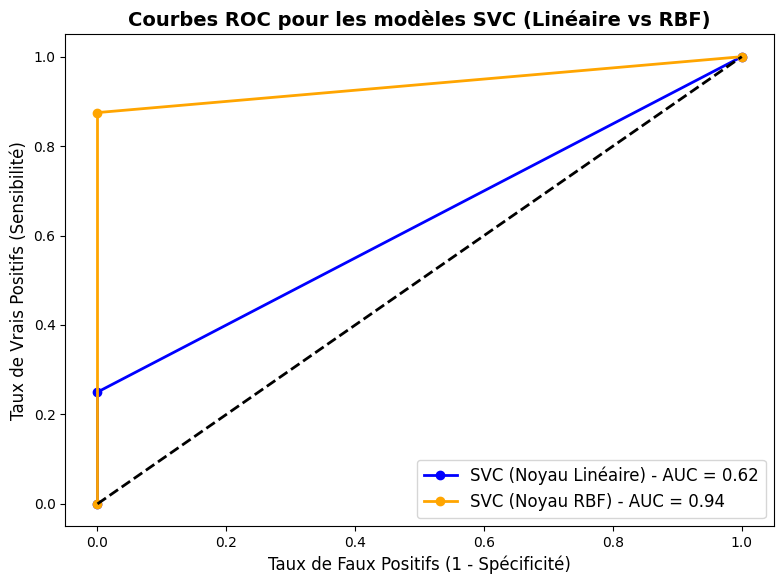

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr_lin, tpr_lin, _ = roc_curve(y_test, y_pred_lin)  # ROC pour le modèle SVC avec noyau linéaire
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_pred_rbf)  # ROC pour le modèle SVC avec noyau RBF

auc_lin = auc(fpr_lin, tpr_lin)  # AUC pour le modèle SVC avec noyau linéaire
auc_rbf = auc(fpr_rbf, tpr_rbf)  # AUC pour le modèle SVC avec noyau RBF

plt.figure(figsize=(8, 6))

plt.plot(fpr_lin, tpr_lin, label=f'SVC (Noyau Linéaire) - AUC = {auc_lin:.2f}', linewidth=2, marker='o', markersize=6, markerfacecolor='blue', color='blue')
plt.plot(fpr_rbf, tpr_rbf, label=f'SVC (Noyau RBF) - AUC = {auc_rbf:.2f}', linewidth=2, marker='o', markersize=6, markerfacecolor='orange', color='orange')

# Tracer la ligne diagonale (modèle aléatoire avec AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)

plt.rcParams['font.size'] = 12
plt.title('Courbes ROC pour les modèles SVC (Linéaire vs RBF)', fontsize=14, fontweight='bold')

plt.xlabel('Taux de Faux Positifs (1 - Spécificité)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (Sensibilité)', fontsize=12)

plt.legend(loc='lower right', fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.savefig("../Image/ROC_SVM.png")
plt.show()

#### Critique 

Nous pouvons conclure qu'avec cet ensemble de données, le modèle SVM avec noyau RBF donne de meilleurs résultats en termes de précision (accuracy), F1-score, courbe ROC, et AUC = 0.92. Nous allons utiliser ce modèle avec noyau RBF pour le comparer avec d'autres modèles tels que Naive Bayes, Decision Tree, ou Logistic Regression.

## 5. Exporter les variables

In [18]:
roc_data_rbf = {
    'fpr_rbf': fpr_rbf,
    'tpr_rbf': tpr_rbf,
    'auc_rbf': auc_rbf
}

with open('roc_data_rbf.pkl', 'wb') as file:
    pickle.dump(roc_data_rbf, file)
print("Les données ont été enregistrées avec succès dans 'variables.pkl'.")

Les données ont été enregistrées avec succès dans 'variables.pkl'.
